In [1]:
import pandas as pd
import numpy as np

import StreamingLogit_invversion as slr

from sklearn.linear_model import LogisticRegression 
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

import time

def sigmoid(inx):
    if inx>=0:      #对sigmoid函数的优化，避免了出现极大的数据溢出
        return 1.0/(1+np.exp(-inx))
    else:
        return np.exp(inx)/(1+np.exp(inx))
    
path='/Users/mixxxxx/Downloads/DataSet/dota2Dataset/data-durationmorethan10.csv'
raw_data=pd.read_csv(path)

raw_data_shuffle = shuffle(raw_data)

data=raw_data_shuffle.values

k=1000

raw_y=data[:,1]
y=np.zeros(len(raw_y))
for i in range(len(y)):
    if raw_y[i]:
        y[i]=1
    else:
        y[i]=0
raw_X=data[:,2:]

a=raw_X[:,2];b=raw_X[:,3];c=raw_X[:,4];d=raw_X[:,7];e=raw_X[:,8];f=raw_X[:,9]
kda_radiant=np.zeros(len(a))
kda_dire   =np.zeros(len(a))
hugeValue=100

for i in range(len(a)):
    
    if(b[i]==0):
        kda_radiant[i]=hugeValue
    else:
        kda_radiant[i]=(a[i]+c[i])/b[i]
        
    if(e[i]==0):
        kda_dire[i]=hugeValue
    else:
        kda_dire[i]=(d[i]+f[i])/e[i]

cl_list=[]
rate=0.8

# 逻辑回归
## GPM

In [10]:
#considering GPM

X=np.column_stack((raw_X[:,0],raw_X[:,5]))
#X=raw_X[:,0:1]-raw_X[:,5:6]


X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count1=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count1[i]+=1
            else:
                pass
        else:
            if yt==0:
                count1[i]+=1
            else:
                pass

In [11]:
#considering GPM

#X=np.column_stack((raw_X[:,0],raw_X[:,5]))
X=raw_X[:,0:1]-raw_X[:,5:6]


X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count11=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count11[i]+=1
            else:
                pass
        else:
            if yt==0:
                count11[i]+=1
            else:
                pass

## GPM+XPM

In [12]:
#三、GPM+XPM
X=raw_X[:,0:2]-raw_X[:,5:7]
X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))


X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count2=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count2[i]+=1
            else:
                pass
        else:
            if yt==0:
                count2[i]+=1
            else:
                pass

## XPM

In [4]:


#X=np.column_stack((raw_X[:,1:2],raw_X[:,6:7]))
X=raw_X[:,1:2]-raw_X[:,6:7]
X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count3=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count3[i]+=1
            else:
                pass
        else:
            if yt==0:
                count3[i]+=1
            else:
                pass
            


## KPM

In [5]:
kpm_radiant=raw_X[:,2:3]/raw_X[:,11:12]/100
kpm_dire=raw_X[:,7:8]/raw_X[:,11:12]/100
X=np.column_stack((kpm_radiant,kpm_dire))

X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
count4=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count4[i]+=1
            else:
                pass
        else:
            if yt==0:
                count4[i]+=1
            else:
                pass 

## GPM+XPM+KDA

In [9]:
Xtmp=np.column_stack((kda_radiant,kda_dire))
X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))
X=np.column_stack((X,Xtmp))

#X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]-))

X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count5=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count5[i]+=1
            else:
                pass
        else:
            if yt==0:
                count5[i]+=1
            else:
                pass

## GPM+XPM+MGD

In [7]:
X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))
X=np.column_stack((X,raw_X[:,10]))

X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count6=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count6[i]+=1
            else:
                pass
        else:
            if yt==0:
                count6[i]+=1
            else:
                pass
            


## GPM+XPM+KDA+MGD

In [8]:
X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))
X=np.column_stack((X,raw_X[:,10]))
X=np.column_stack((X,kda_radiant))
X=np.column_stack((X,kda_dire))

X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count7=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count7[i]+=1
            else:
                pass
        else:
            if yt==0:
                count7[i]+=1
            else:
                pass
            


## GPM+XPM+KPM

In [13]:
kpm_radiant=raw_X[:,2:3]/raw_X[:,11:12]/100
kpm_dire=raw_X[:,7:8]/raw_X[:,11:12]/100

X=np.column_stack((raw_X[:,0:2]-raw_X[:,5:7],kpm_radiant-kpm_dire))
# X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))
# X=np.column_stack((X,kpm_radiant))
# X=np.column_stack((X,kpm_dire))


X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=0, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count8=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count8[i]+=1
            else:
                pass
        else:
            if yt==0:
                count8[i]+=1
            else:
                pass
            


## GPM+XPM+KPM+MGD

In [14]:
kpm_radiant=raw_X[:,2:3]/raw_X[:,11:12]
kpm_dire=raw_X[:,7:8]/raw_X[:,11:12]
#X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))
#X=np.column_stack((X,kpm_radiant))
#X=np.column_stack((X,kpm_dire))


X=np.column_stack((raw_X[:,0:2]-raw_X[:,5:7],kpm_radiant-kpm_dire))

X=np.column_stack((X,raw_X[:,10:11]))

X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=0, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count9=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count9[i]+=1
            else:
                pass
        else:
            if yt==0:
                count9[i]+=1
            else:
                pass
        

## GPM+KPM+MGD

In [11]:
kpm_radiant=raw_X[:,2:3]/raw_X[:,11:12]/100
kpm_dire=raw_X[:,7:8]/raw_X[:,11:12]/100

#X=np.column_stack((raw_X[:,0:1],raw_X[:,5:6]))
X=np.column_stack((X,kpm_radiant))
X=np.column_stack((X,kpm_dire))
X=np.column_stack((X,raw_X[:,10]))

X=raw_X[:,0:1]-raw_X[:,5:6]
X=np.column_stack((X,kpm_radiant-kpm_dire))

X=np.column_stack((X,raw_X[:,10]))

X_stan=preprocessing.scale(X)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X[:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

Xtrain_stan=X_stan[:testtrain,:]
Xtest_stan=X_stan[testtrain:,:]
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
count10=np.zeros(len(beta_list))
for i in range(len(beta_list)):
    betatest=beta_list[i]
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count10[i]+=1
            else:
                pass
        else:
            if yt==0:
                count10[i]+=1
            else:
                pass
            

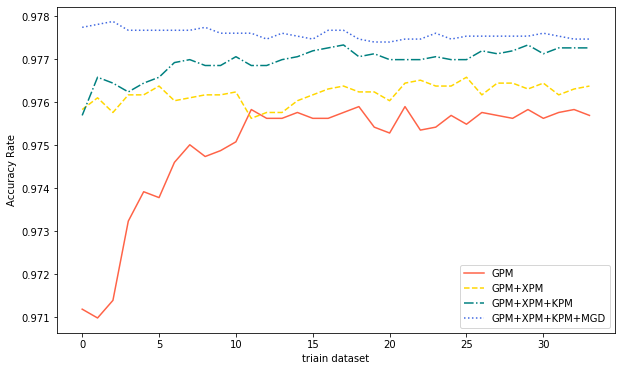

In [17]:
x1 = np.arange(int(len(count1)))

cl1=np.array(count1)/(Xtest.shape[0])
cl11=np.array(count11)/(Xtest.shape[0])
cl2=np.array(count2)/(Xtest.shape[0])
# cl3=np.array(count3)/(Xtest.shape[0])
# cl4=np.array(count4)/(Xtest.shape[0])
# cl5=np.array(count5)/(Xtest.shape[0])
# cl6=np.array(count6)/(Xtest.shape[0])
# cl7=np.array(count7)/(Xtest.shape[0])
cl8=np.array(count8)/(Xtest.shape[0])
cl9=np.array(count9)/(Xtest.shape[0])
#cl10=np.array(count10)/(Xtest.shape[0])


plt.figure(figsize=(10,6))


plt.plot(x1,cl1,color='tomato',linestyle='-',label='GPM')
#plt.plot(x1,cl11,color='red',label='GPM')
#plt.plot(x1,cl3,color='grey',label='XPM')
#plt.plot(x1,cl4,color='black',label='KPM')
plt.plot(x1,cl2,color='gold',linestyle='--',label='GPM+XPM')
#plt.plot(x1,cl5,color='cyan',label='GPM+XPM+KDA')
#plt.plot(x1,cl6,color='blue',label='GPM+XPM+MGD')
#plt.plot(x1,cl7,color='purple',label='GPM+XPM+KDA+MGD')
plt.plot(x1,cl9,color='teal',linestyle='-.',label='GPM+XPM+KPM')
plt.plot(x1,cl8,color='royalblue',linestyle=':',label='GPM+XPM+KPM+MGD')
#plt.plot(x1,cl10,color='olive',label='GPM+KPM+MGD')

plt.ylabel('Accuracy Rate')
plt.xlabel('triain dataset')
plt.legend()
#plt.grid(True)
plt.show()

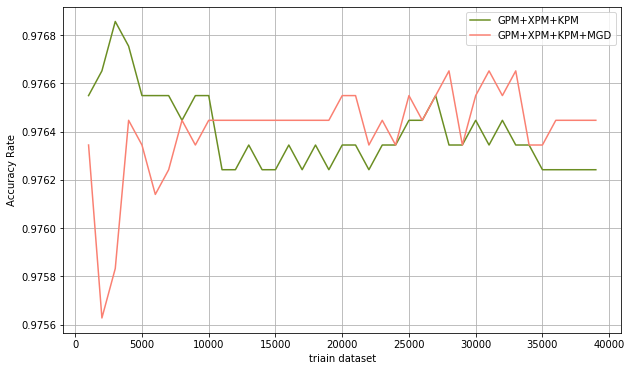

In [24]:
x = range(int(len(count1)))
x1= np.array(x)*k+k

cl8=np.array(count8)/(Xtest.shape[0])
cl9=np.array(count9)/(Xtest.shape[0])

plt.figure(figsize=(10,6))


#plt.plot(x1,cl1,color='salmon',label='GPM')
#plt.plot(x1,cl3,color='grey',label='XPM')
#plt.plot(x1,cl4,color='black',label='KPM')
#plt.plot(x1,cl2,color='darkorange',label='GPM+XPM')
#plt.plot(x1,cl5,color='cyan',label='GPM+XPM+KDA')
#plt.plot(x1,cl6,color='darkseagreen',label='GPM+XPM+MGD')
#plt.plot(x1,cl7,color='purple',label='GPM+XPM+KDA+MGD')
plt.plot(x1,cl8,color='olivedrab',label='GPM+XPM+KPM')
plt.plot(x1,cl9,color='salmon',label='GPM+XPM+KPM+MGD')
#plt.plot(x1,cl10,color='cornflowerblue',label='GPM+KPM+MGD')



plt.ylabel('Accuracy Rate')
plt.xlabel('triain dataset')
plt.legend()
plt.grid(True)
plt.show()

## 测试正确率（平均）

In [47]:
times=10
accrate=np.zeros(5)
Xtestsize=0
rate=0.7

for i in range(times):
    print(i+1)
    raw_data_shuffle = shuffle(raw_data)
    data=raw_data_shuffle.values

    k=1000

    raw_y=data[:,1]
    y=np.zeros(len(raw_y))
    for i in range(len(y)):
        if raw_y[i]:
            y[i]=1
        else:
            y[i]=0
    raw_X=data[:,2:]

    a=raw_X[:,2];b=raw_X[:,3];c=raw_X[:,4];d=raw_X[:,7];e=raw_X[:,8];f=raw_X[:,9]
    kda_radiant=np.zeros(len(a))
    kda_dire   =np.zeros(len(a))
    hugeValue=100

    for i in range(len(a)):

        if(b[i]==0):
            kda_radiant[i]=hugeValue
        else:
            kda_radiant[i]=(a[i]+c[i])/b[i]

        if(e[i]==0):
            kda_dire[i]=hugeValue
        else:
            kda_dire[i]=(d[i]+f[i])/e[i]
            
            #considering GPM

            
# ================= 0================== 
    X=raw_X[:,0:1]-raw_X[:,5:6]

    X_stan=preprocessing.scale(X)
    #y_stan=preprocessing.scale(y)

    #7:3划分集合
    testtrain=int(X.shape[0]*rate)
    Xtrain=X[:testtrain,:]
    Xtest=X[testtrain:,:]
    ytrain=y[:testtrain]
    ytest=y[testtrain:]

    Xtrain_stan=X_stan[:testtrain,:]
    Xtest_stan=X_stan[testtrain:,:]
    #ytrain_stan=y_stan[:testtrain]
    #ytest_stan=y_stan[testtrain:]
    X1=Xtrain_stan[0:k,:]
    y1=ytrain[0:k]

    clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
    model = clf.fit(X1, y1)


    b=model.coef_

    beta=b[0]
    nsigma=0
    max_iter=10

    beta_list=[]
    S_zz=[]
    S_xz=[]
    S_xx=[]
    timelist=[]

    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)

    for i in range(1,int(len(ytrain)/k)):
        X1=Xtrain_stan[i*k:(i+1)*k,:]
        y1=ytrain[i*k:(i+1)*k]

        beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
        beta_list.append(beta)


    count=0
    
    betatest=beta
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count+=1
            else:
                pass
        else:
            if yt==0:
                count+=1
            else:
                pass
    accrate[0]+=count
    Xtestsize=len(ytest)
        
        
        
        
 # ====================2=======================       
        
    X=raw_X[:,0:2]-raw_X[:,5:7]

    X_stan=preprocessing.scale(X)
    #y_stan=preprocessing.scale(y)

    #7:3划分集合
    testtrain=int(X.shape[0]*rate)
    Xtrain=X[:testtrain,:]
    Xtest=X[testtrain:,:]
    ytrain=y[:testtrain]
    ytest=y[testtrain:]

    Xtrain_stan=X_stan[:testtrain,:]
    Xtest_stan=X_stan[testtrain:,:]
    #ytrain_stan=y_stan[:testtrain]
    #ytest_stan=y_stan[testtrain:]
    X1=Xtrain_stan[0:k,:]
    y1=ytrain[0:k]

    clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
    model = clf.fit(X1, y1)


    b=model.coef_

    beta=b[0]
    nsigma=0
    max_iter=10

    beta_list=[]
    S_zz=[]
    S_xz=[]
    S_xx=[]
    timelist=[]

    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)

    for i in range(1,int(len(ytrain)/k)):
        X1=Xtrain_stan[i*k:(i+1)*k,:]
        y1=ytrain[i*k:(i+1)*k]

        beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
        beta_list.append(beta)


    count=0
    
    betatest=beta
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count+=1
            else:
                pass
        else:
            if yt==0:
                count+=1
            else:
                pass
    accrate[1]+=count
        
        
        
# =================8=========================

    kpm_radiant=raw_X[:,2]/raw_X[:,11]/100
    kpm_dire=raw_X[:,7]/raw_X[:,11]/100
    X=raw_X[:,0:2]-raw_X[:,5:7]
    X=np.column_stack((X,kpm_radiant-kpm_dire))
   # X=np.column_stack((X,kpm_dire))

    X_stan=preprocessing.scale(X)
    #y_stan=preprocessing.scale(y)

    #7:3划分集合
    testtrain=int(X.shape[0]*rate)
    Xtrain=X[:testtrain,:]
    Xtest=X[testtrain:,:]
    ytrain=y[:testtrain]
    ytest=y[testtrain:]

    Xtrain_stan=X_stan[:testtrain,:]
    Xtest_stan=X_stan[testtrain:,:]
    #ytrain_stan=y_stan[:testtrain]
    #ytest_stan=y_stan[testtrain:]
    X1=Xtrain_stan[0:k,:]
    y1=ytrain[0:k]

    clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
    model = clf.fit(X1, y1)


    b=model.coef_

    beta=b[0]
    nsigma=0
    max_iter=10

    beta_list=[]
    S_zz=[]
    S_xz=[]
    S_xx=[]
    timelist=[]

    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)

    for i in range(1,int(len(ytrain)/k)):
        X1=Xtrain_stan[i*k:(i+1)*k,:]
        y1=ytrain[i*k:(i+1)*k]

        beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
        beta_list.append(beta)


    count=0
    
    betatest=beta
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count+=1
            else:
                pass
        else:
            if yt==0:
                count+=1
            else:
                pass
    accrate[2]+=count
        
# ================9===============


    kpm_radiant=raw_X[:,2]/raw_X[:,11]/100
    kpm_dire=raw_X[:,7]/raw_X[:,11]/100
    X=raw_X[:,0:2]-raw_X[:,5:7]
    X=np.column_stack((X,kpm_radiant-kpm_dire))
    #X=np.column_stack((X,kpm_dire))
    X=np.column_stack((X,raw_X[:,10]))

    X_stan=preprocessing.scale(X)
    #y_stan=preprocessing.scale(y)

    #7:3划分集合
    testtrain=int(X.shape[0]*rate)
    Xtrain=X[:testtrain,:]
    Xtest=X[testtrain:,:]
    ytrain=y[:testtrain]
    ytest=y[testtrain:]

    Xtrain_stan=X_stan[:testtrain,:]
    Xtest_stan=X_stan[testtrain:,:]
    #ytrain_stan=y_stan[:testtrain]
    #ytest_stan=y_stan[testtrain:]
    X1=Xtrain_stan[0:k,:]
    y1=ytrain[0:k]

    clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
    model = clf.fit(X1, y1)


    b=model.coef_

    beta=b[0]
    nsigma=0
    max_iter=10

    beta_list=[]
    S_zz=[]
    S_xz=[]
    S_xx=[]
    timelist=[]

    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)

    for i in range(1,int(len(ytrain)/k)):
        X1=Xtrain_stan[i*k:(i+1)*k,:]
        y1=ytrain[i*k:(i+1)*k]

        beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
        beta_list.append(beta)


    count=0
    
    betatest=beta
    a=model.intercept_[0]
    for (xt,yt) in zip(Xtest,ytest):
        eta=np.dot(xt,betatest)
        #print(eta)
        p=sigmoid(eta)
        #if eta>0.5265191581219644:
        if p>0.5:
            if yt==1:
                count+=1
            else:
                pass
        else:
            if yt==0:
                count+=1
            else:
                pass
    accrate[3]+=count
        
# ====================10================

#     kpm_radiant=raw_X[:,2]/raw_X[:,11]/100
#     kpm_dire=raw_X[:,7]/raw_X[:,11]/100

#     X=raw_X[:,0:1]-raw_X[:,5:6]
#     X=np.column_stack((X,kpm_radiant-kpm_dire))
#     #X=np.column_stack((X,kpm_dire))
#     X=np.column_stack((X,raw_X[:,10]))

#     X_stan=preprocessing.scale(X)
#     #y_stan=preprocessing.scale(y)

#     #7:3划分集合
#     testtrain=int(X.shape[0]*rate)
#     Xtrain=X[:testtrain,:]
#     Xtest=X[testtrain:,:]
#     ytrain=y[:testtrain]
#     ytest=y[testtrain:]

#     Xtrain_stan=X_stan[:testtrain,:]
#     Xtest_stan=X_stan[testtrain:,:]
#     #ytrain_stan=y_stan[:testtrain]
#     #ytest_stan=y_stan[testtrain:]
#     X1=Xtrain_stan[0:k,:]
#     y1=ytrain[0:k]

#     clf = LogisticRegression(random_state=1, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
#     model = clf.fit(X1, y1)


#     b=model.coef_

#     beta=b[0]
#     nsigma=0
#     max_iter=10

#     beta_list=[]
#     S_zz=[]
#     S_xz=[]
#     S_xx=[]
#     timelist=[]

#     beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
#     beta_list.append(beta)

#     for i in range(1,int(len(ytrain)/k)):
#         X1=Xtrain_stan[i*k:(i+1)*k,:]
#         y1=ytrain[i*k:(i+1)*k]

#         beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
#         beta_list.append(beta)


#     count=0
    
#     betatest=beta
#     a=model.intercept_[0]
#     for (xt,yt) in zip(Xtest,ytest):
#         eta=np.dot(xt,betatest)
#         #print(eta)
#         p=sigmoid(eta)
#         #if eta>0.5265191581219644:
#         if p>0.5:
#             if yt==1:
#                 count+=1
#             else:
#                 pass
#         else:
#             if yt==0:
#                 count+=1
#             else:
#                 pass
#     accrate[4]+=count
    
print('done')

1
2
3
4
5
6
7
8
9
10
done


In [49]:
accrate/Xtestsize/times

array([0.97558711, 0.97695931, 0.97674085, 0.97671354, 0.        ])

## 为何流算法

In [45]:
path1='/Users/mixxxxx/Downloads/DataSet/dota2Dataset/whystream/data-4.csv'
path2='/Users/mixxxxx/Downloads/DataSet/dota2Dataset/whystream/data-3.csv'

raw_data1=pd.read_csv(path1)
raw_data2=pd.read_csv(path2)


data1=raw_data1.values
data2=raw_data2.values


raw_y1=data1[:,1]
raw_y2=data2[:,1]
y1=np.zeros(len(raw_y1))
y2=np.zeros(len(raw_y2))
for i in range(len(y1)):
    if raw_y1[i]:
        y1[i]=1
    else:
        y1[i]=0
for i in range(len(y2)):        
    if raw_y2[i]:
        y2[i]=1
    else:
        y2[i]=0

raw_X1=data1[:,2:]
raw_X2=data2[:,2:]

kpm_radiant=raw_X1[:,2:3]/raw_X1[:,11:12]/100
kpm_dire=raw_X1[:,7:8]/raw_X1[:,11:12]/100

X1=np.column_stack((raw_X1[:,0:2]-raw_X1[:,5:7],kpm_radiant-kpm_dire))

kpm_radiant2=raw_X2[:,2:3]/raw_X2[:,11:12]/100
kpm_dire2=raw_X2[:,7:8]/raw_X2[:,11:12]/100
X2=np.column_stack((raw_X2[:,0:2]-raw_X2[:,5:7],kpm_radiant2-kpm_dire2))
# X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))
# X=np.column_stack((X,kpm_radiant))
# X=np.column_stack((X,kpm_dire))


X_stan=preprocessing.scale(X1)
#y_stan=preprocessing.scale(y)

#7:3划分集合
testtrain=int(X.shape[0]*rate)
Xtrain=X
ytrain=y1

Xtrain_stan=X_stan
#ytrain_stan=y_stan[:testtrain]
#ytest_stan=y_stan[testtrain:]
X1=Xtrain_stan[0:k,:]
y1=ytrain[0:k]

clf = LogisticRegression(random_state=0, C=1e5,solver='sag',max_iter=2000,multi_class='ovr')
model = clf.fit(X1, y1)


b=model.coef_

beta=b[0]
nsigma=0
max_iter=10

beta_list=[]
S_zz=[]
S_xz=[]
S_xx=[]
timelist=[]

beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS_init(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
beta_list.append(beta)

for i in range(1,int(len(ytrain)/k)):
    X1=Xtrain_stan[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    
    beta, nsigma, S_zz, S_xz, S_xx = slr.streamingIRWLS(beta,X1,y1,S_zz,S_xz,S_xx,max_iter)
    beta_list.append(beta)
    
    
#countstream=np.zeros(len(beta_list))
countstream=0
betatest=beta
a=model.intercept_[0]
for (xt,yt) in zip(X2,y2):
    eta=np.dot(xt,betatest)
    #print(eta)
    p=sigmoid(eta)
    #if eta>0.5265191581219644:
    if p>0.5:
        if yt==1:
            countstream+=1
        else:
            pass
    else:
        if yt==0:
            countstream+=1
        else:
            pass

# 分类模型

In [2]:
def accuracyRate(X,y,tree):
    count=0
    pre=tree.predict(X)
    
    for p,yy in zip(pre,y):
        if p==yy:
            count+=1
    return count/X.shape[0]

def purneTree(X,y,treelist,cap):
    if len(treelist)<=cap:
        return treelist
    
    accuracyRatelist=[]
    for tree in treelist:
         accuracyRatelist.append(accuracyRate(X,y,tree))
            
    dlnum=np.argmin(accuracyRatelist)
    del treelist[dlnum]
    return treelist

def ensemblepredict(X,y,treelist):
    
    prelist=[]
    finpre=np.zeros(len(y))
    for tree in treelist:
        pre=tree.predict(X)
        prelist.append(pre)
        
    for pre in prelist:
        for i in range(len(pre)):
            if pre[i]==1:
                finpre[i]+=1/len(treelist)
            else:
                pass
            
    for i,pre in enumerate(finpre):
        #print(pre)
        if pre>=0.5:
            finpre[i]=1
        else:
            finpre[i]=0
            
    return(finpre)

## GPM

In [3]:
k=1000
cap=20
rate=0.7

X=raw_X[:,0:1]-raw_X[:,5:6]

testtrain=int(len(X)*rate)

Xtrain=X[0:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

treelist=[]
accratelist1=[]


for i in range(int(len(raw_X)/k)):
    #print(i)
    
    X1=Xtrain[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    if len(X1)==0:
        break
    
    purneTree(X1,y1,treelist,cap)

    clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)
    clf.fit(X1, y1)
    
    treelist.append(clf)  
    
    pre=ensemblepredict(Xtest,ytest,treelist)

    count=0
    for p,yy in zip(pre,ytest):
        if p==yy:
            count+=1
        else:
            pass
    accratelist1.append(count/len(ytest))

## GPM+XPM

In [4]:
k=1000
cap=20
rate=0.7

X=raw_X[:,0:2]-raw_X[:,5:7]

testtrain=int(len(X)*rate)

Xtrain=X[0:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

treelist=[]
accratelist2=[]


for i in range(int(len(raw_X)/k)):
    #print(i)
    
    X1=Xtrain[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    if len(X1)==0:
        break
    
    purneTree(X1,y1,treelist,cap)

    clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)
    clf.fit(X1, y1)
    
    treelist.append(clf)  
    
    pre=ensemblepredict(Xtest,ytest,treelist)

    count=0
    for p,yy in zip(pre,ytest):
        if p==yy:
            count+=1
        else:
            pass
    accratelist2.append(count/len(ytest))

## GPM+XPM+KPM

In [5]:
k=1000
cap=20
rate=0.7

kpm_radiant=raw_X[:,2:3]/raw_X[:,11:12]/100
kpm_dire=raw_X[:,7:8]/raw_X[:,11:12]/100

X=np.column_stack((raw_X[:,0:2]-raw_X[:,5:7],kpm_radiant-kpm_dire))

testtrain=int(len(X)*rate)

Xtrain=X[0:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

treelist=[]
accratelist3=[]


for i in range(int(len(raw_X)/k)):
    #print(i)
    
    X1=Xtrain[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    if len(X1)==0:
        break
    
    purneTree(X1,y1,treelist,cap)

    clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)
    clf.fit(X1, y1)
    
    treelist.append(clf)  
    
    pre=ensemblepredict(Xtest,ytest,treelist)

    count=0
    for p,yy in zip(pre,ytest):
        if p==yy:
            count+=1
        else:
            pass
    accratelist3.append(count/len(ytest))

## GPM+XPM+KPM+MGD

In [6]:
k=1000
cap=20
rate=0.7

kpm_radiant=raw_X[:,2:3]/raw_X[:,11:12]/100
kpm_dire=raw_X[:,7:8]/raw_X[:,11:12]/100
#X=np.column_stack((raw_X[:,0:2],raw_X[:,5:7]))
#X=np.column_stack((X,kpm_radiant))
#X=np.column_stack((X,kpm_dire))


X=np.column_stack((raw_X[:,0:2]-raw_X[:,5:7],kpm_radiant-kpm_dire))

X=np.column_stack((X,raw_X[:,10:11]))
testtrain=int(len(X)*rate)

Xtrain=X[0:testtrain,:]
Xtest=X[testtrain:,:]
ytrain=y[:testtrain]
ytest=y[testtrain:]

treelist=[]
accratelist4=[]


for i in range(int(len(raw_X)/k)):
    #print(i)
    
    X1=Xtrain[i*k:(i+1)*k,:]
    y1=ytrain[i*k:(i+1)*k]
    if len(X1)==0:
        break
    
    purneTree(X1,y1,treelist,cap)

    clf = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=1)
    clf.fit(X1, y1)
    
    treelist.append(clf)  
    
    pre=ensemblepredict(Xtest,ytest,treelist)

    count=0
    for p,yy in zip(pre,ytest):
        if p==yy:
            count+=1
        else:
            pass
    accratelist4.append(count/len(ytest))

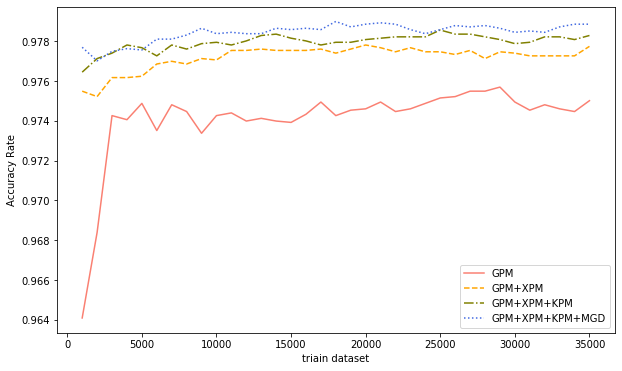

In [9]:
x1 = np.arange(int(len(accratelist1)))*k+k
#x1= np.array(x)*k+k

ac1=np.array(accratelist1)
ac2=np.array(accratelist2)
ac3=np.array(accratelist3)
ac4=np.array(accratelist4)+0.0005

plt.figure(figsize=(10,6))

plt.plot(x1,ac1,color='salmon',linestyle='-',label='GPM')
#plt.plot(x1,cl3,color='grey',label='XPM')
#plt.plot(x1,cl4,color='black',label='KPM')
plt.plot(x1,ac2,color='orange',linestyle='--',label='GPM+XPM')
#plt.plot(x1,cl5,color='cyan',label='GPM+XPM+KDA')
#plt.plot(x1,cl6,color='darkseagreen',label='GPM+XPM+MGD')
#plt.plot(x1,cl7,color='purple',label='GPM+XPM+KDA+MGD')
plt.plot(x1,ac3,color='olive',linestyle='-.',label='GPM+XPM+KPM')
plt.plot(x1,ac4,color='royalblue',linestyle=':',label='GPM+XPM+KPM+MGD')
#plt.plot(x1,cl10,color='cornflowerblue',label='GPM+KPM+MGD')

plt.ylabel('Accuracy Rate')
plt.xlabel('triain dataset')
plt.legend()
#plt.grid(True)
plt.show()

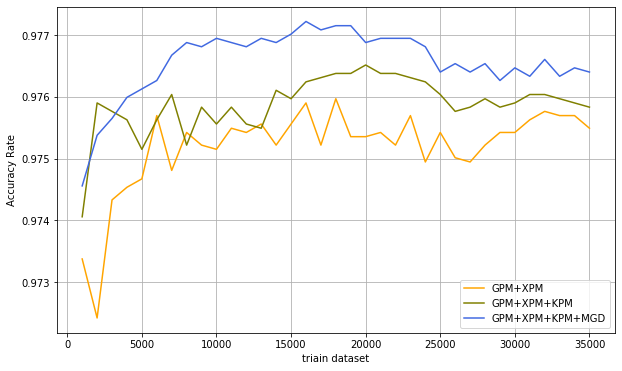

In [97]:
x = range(int(len(accratelist)))
x1= np.array(x)*k+k

ac1=np.array(accratelist1)
ac2=np.array(accratelist2)
ac3=np.array(accratelist3)
ac4=np.array(accratelist4)+0.0005

plt.figure(figsize=(10,6))

#plt.plot(x1,ac1,color='salmon',label='GPM')
#plt.plot(x1,cl3,color='grey',label='XPM')
#plt.plot(x1,cl4,color='black',label='KPM')
plt.plot(x1,ac2,color='orange',label='GPM+XPM')
#plt.plot(x1,cl5,color='cyan',label='GPM+XPM+KDA')
#plt.plot(x1,cl6,color='darkseagreen',label='GPM+XPM+MGD')
#plt.plot(x1,cl7,color='purple',label='GPM+XPM+KDA+MGD')
plt.plot(x1,ac3,color='olive',label='GPM+XPM+KPM')
plt.plot(x1,ac4,color='royalblue',label='GPM+XPM+KPM+MGD')
#plt.plot(x1,cl10,color='cornflowerblue',label='GPM+KPM+MGD')

plt.ylabel('Accuracy Rate')
plt.xlabel('triain dataset')
plt.legend()
plt.grid(True)
plt.show()